In [1]:
from collections import Counter
import sys

In [2]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import xarray as xr

In [3]:
sys.path.append('../src/lib/')
import plot

## Load Data ##

Factors calculated on the Imagene gene expression data set.

In [4]:
sfa = xr.open_dataset('../models/sfa.nc')
sfa['factor_name'] = ('factor', np.array([
    'ER',
    'EMT',
    'Luminal Proliferative',
    'Technical RNA-seq',
    'Technical RPPA',
    'Immune',
    'HER2',
    'Normal-like / ILC',
    'Basal',
    'Chr8'
], 'object'))
sfa

<xarray.Dataset>
Dimensions:      (factor: 10, patient: 304)
Coordinates:
  * factor       (factor) object 'Factor 1' 'Factor 2' 'Factor 3' 'Factor 4' ...
  * patient      (patient) int64 1237 976 1382 480 1016 630 636 859 196 367 ...
Data variables:
    factors      (factor, patient) float64 -0.2269 1.02 -0.4513 -0.1683 ...
    factor_name  (factor) object 'ER' 'EMT' 'Luminal Proliferative' ...

MRI features from the same patients.

In [5]:
mri = xr.open_dataset('../data/processed/mri-features.nc')
mri = mri.reindex(patient=sfa['patient'])
assert all(mri['patient'].values == sfa['patient'].values)
mri

<xarray.Dataset>
Dimensions:                              (patient: 304)
Coordinates:
  * patient                              (patient) int64 1237 976 1382 480 ...
Data variables:
    Comment                              (patient) object Tumor segmenter fails ...
    MultiFocal                           (patient) float64 nan 0.0 0.0 0.0 ...
    circularity                          (patient) float64 nan 0.8088 0.7688 ...
    irregularity                         (patient) float64 nan 0.3999 0.4762 ...
    volume                               (patient) float64 nan 1.398e+03 ...
    largest_diameter                     (patient) float64 nan 19.88 21.93 ...
    mean_vox_val                         (patient) float64 nan 90.0 81.0 ...
    variance_vox_val                     (patient) float64 nan 2.536e+03 ...
    uptake_speed                         (patient) float64 nan 1.698 1.768 ...
    washout                              (patient) float64 nan 0.1604 0.1747 ...
    ser                 

And clinical variables.

In [6]:
clin = pd.read_table('../data/raw/imagene_clinical.tsv')
clin = clin.set_index('margins_patient')
clin.index.name = 'patient'
clin = clin.to_xarray()
clin = clin.reindex(patient=sfa['patient'])
assert(np.all(clin['patient'].values == sfa['patient'].values))
clin

<xarray.Dataset>
Dimensions:               (patient: 304)
Coordinates:
  * patient               (patient) int64 1237 976 1382 480 1016 630 636 859 ...
Data variables:
    rna_sample            (patient) object 'CF5171' 'CF5088' 'CF5198' ...
    pos_LN                (patient) float64 0.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 ...
    largest_diameter_MRI  (patient) float64 18.0 54.0 30.0 25.0 32.0 23.0 ...
    histograde            (patient) float64 3.0 3.0 3.0 3.0 2.0 2.0 1.0 3.0 ...
    age_at_diag           (patient) float64 72.62 66.34 59.5 54.86 31.0 ...
    ihc_subtype           (patient) object 'ER+/HER2-' 'HER2+' 'ER+/HER2-' ...
    AdjRT                 (patient) object 'T' 'T' 'T' 'T' 'F' 'T' 'T' 'T' ...
    AdjChemo              (patient) object 'F' 'F' 'F' 'T' 'T' 'F' 'F' 'F' ...
    AdjHormo              (patient) object 'F' 'T' 'T' 'T' 'T' 'T' 'F' 'T' ...
    AdjAntiHER2           (patient) object 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' ...
    AdjSystemic           (patient) object 'F' 'T

In [7]:
Counter(clin['ihc_subtype'].values)

Counter({'ER+/HER2-': 237, 'HER2+': 30, nan: 3, 'TN': 34})

Select samples with no missing values for MRI features, and put them into an array.

In [8]:
mri_features = list(set(mri.keys()) - {'patient', 'Comment', 'MultiFocal'})
mri_array = mri[mri_features].to_array()

## Supporting Functions ##

In [9]:
def plot_roc(y_true, y_score):
    """Plot a ROC curve for binary true y and predicted y scores."""
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    auc = sklearn.metrics.auc(fpr, tpr)
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_title("AUC = {}".format(auc))

In [10]:
def bin_performance(y, y_pred):
    """Display performance for binary classification."""
    if y_pred.dtype != np.bool:
        y_pred = y_pred > 0.5
    
    return dict({
        'Accuracy': np.mean(y == y_pred),
        'Sensitivity': np.sum(y & y_pred) / np.sum(y),
        'Specificity': np.sum(~y & ~y_pred) / np.sum(~y),
        'Precision': np.sum(y & y_pred) / np.sum(y_pred)
    })

In [11]:
def mse_performance(y, y_pred):
    """"Display performance by mean square error."""
    if y_pred.dtype != np.bool:
        y_pred = y_pred > 0.5
    
    return dict({
        'MSE': np.mean((y - y_pred)**2)
    })

In [12]:
class PcaLog():
    """Predictive model by logistic regression of principal components."""
    
    def __init__(self, n_components):
        self.n_components = n_components

    def train(self, X, y):

        self._pca = sklearn.decomposition.PCA(self.n_components)
        X_pc = self._pca.fit_transform(X)

        self._logm = sklearn.linear_model.LogisticRegression()
        self._logm.fit(X_pc, y)
        
    def predict(self, X):
        X_pc = self._pca.transform(X)
        return self._logm.predict_proba(X_pc)[:, 1]

In [13]:
class PcaLin():
    """Predictive model by linear regression of principal components."""
    
    def __init__(self, n_components):
        self.n_components = n_components

    def train(self, X, y):

        self._pca = sklearn.decomposition.PCA(self.n_components)
        X_pc = self._pca.fit_transform(X)

        self._lm = sklearn.linear_model.LinearRegression()
        self._lm.fit(X_pc, y)
        
    def predict(self, X):
        X_pc = self._pca.transform(X)
        return self._lm.predict(X_pc)

# Predict ER status from MRI features #

This as a sanity check for the method. We know we should be able to predict ER status to some extent, and predicting the ER factor should perform similarly.

Number of samples: 256

Performance under null model:

{'Accuracy': 0.87109375,
 'Precision': 0.87109375,
 'Sensitivity': 1.0,
 'Specificity': 0.0}

**Logistic PC Regresion**

{'Accuracy': 0.890625,
 'Precision': 0.89473684210526316,
 'Sensitivity': 0.99103139013452912,
 'Specificity': 0.21212121212121213}

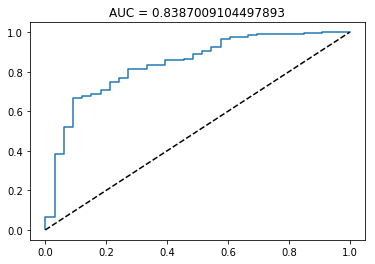

**LOOCV Logistic PC Regresion**

{'Accuracy': 0.87109375,
 'Precision': 0.88617886178861793,
 'Sensitivity': 0.97757847533632292,
 'Specificity': 0.15151515151515152}

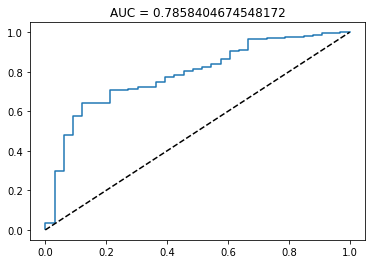

In [14]:
sel_patients = list(
    {p for t, p in zip(clin['ihc_subtype'], clin['patient'].values)
     if t in ['ER+/HER2-', 'TN']} &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values
y = clin['ihc_subtype'].reindex(patient=sel_patients).values == 'ER+/HER2-'

display(Markdown("Number of samples: {}".format(X.shape[0])))

display(Markdown("Performance under null model:"))
display(bin_performance(y, np.ones(len(y))))

display(Markdown("**Logistic PC Regresion**"))

model = PcaLog(10)
model.train(X, y)
y_pred = model.predict(X)
display(bin_performance(y, y_pred))
plot_roc(y, y_pred)

display(Markdown("**LOOCV Logistic PC Regresion**"))

loocv = sklearn.model_selection.LeaveOneOut()
y_pred = np.full(y.shape, np.nan)
for train_index, test_index in loocv.split(X):
    m = PcaLog(10)
    m.train(X[train_index, :], y[train_index])
    y_pred[test_index] = m.predict(X[test_index, :])
display(bin_performance(y, y_pred))
plot_roc(y, y_pred)

# Predict Factors from MRI features in all subtypes #

## Linear Regression ##

Number of samples: 282

##### Factor ER 

{'MSE': 0.88233152873966825}

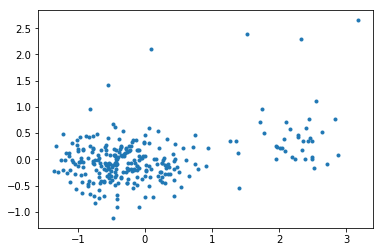

##### Factor EMT 

{'MSE': 1.0006114028692463}

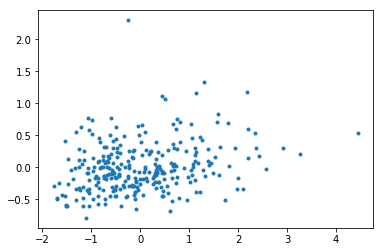

##### Factor Luminal Proliferative 

{'MSE': 1.0040782054123931}

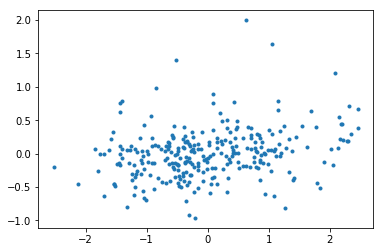

##### Factor Technical RNA-seq 

{'MSE': 0.99390672125446788}

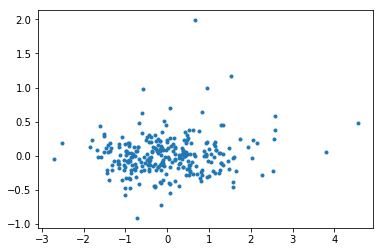

##### Factor Technical RPPA 

{'MSE': 1.0239829433315053}

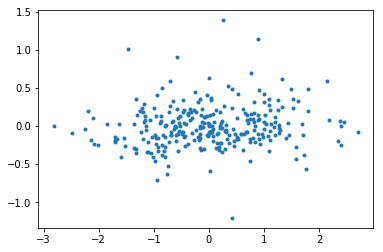

##### Factor Immune 

{'MSE': 1.0122669715009496}

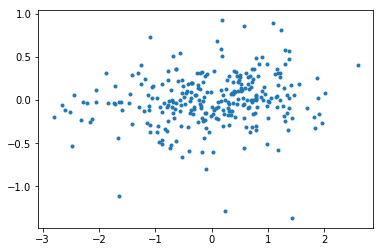

##### Factor HER2 

{'MSE': 1.034606434572106}

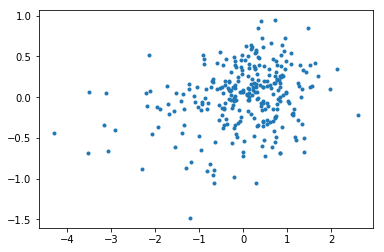

##### Factor Normal-like / ILC 

{'MSE': 0.94672697326452826}

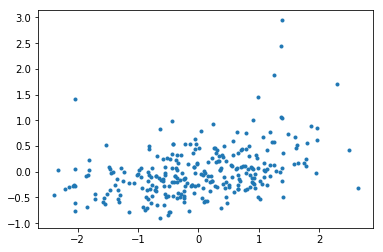

##### Factor Basal 

{'MSE': 1.0450422397777144}

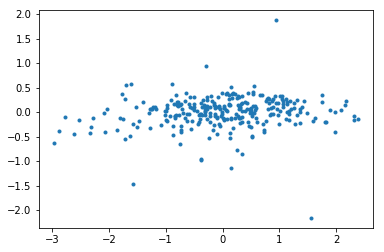

##### Factor Chr8 

{'MSE': 1.0020575294693357}

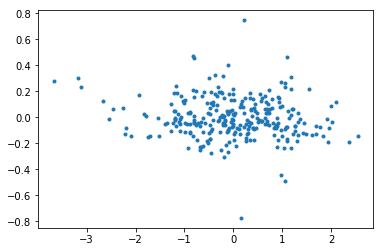

In [15]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values
y = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = (y - np.mean(y, 0, keepdims=True)) / np.std(y, 0, keepdims=True)

display(Markdown("Number of samples: {}".format(X.shape[0])))

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLin(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(mse_performance(y[:, factor_i], y_pred))
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(y[:, factor_i], y_pred, '.')  

## Logistic Regression ##

##### Factor ER 

{'Accuracy': 0.86524822695035464,
 'Precision': 0.58823529411764708,
 'Sensitivity': 0.24390243902439024,
 'Specificity': 0.97095435684647302}

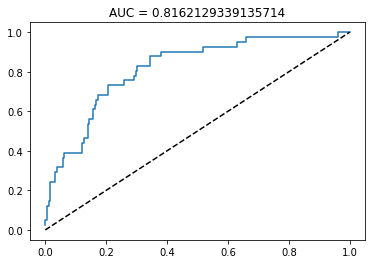

##### Factor EMT 

{'Accuracy': 0.61347517730496459,
 'Precision': 0.5,
 'Sensitivity': 0.25688073394495414,
 'Specificity': 0.83815028901734101}

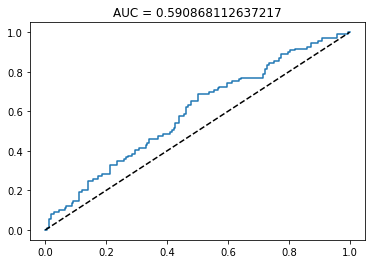

##### Factor Luminal Proliferative 

{'Accuracy': 0.67375886524822692,
 'Precision': 0.6376811594202898,
 'Sensitivity': 0.3963963963963964,
 'Specificity': 0.85380116959064323}

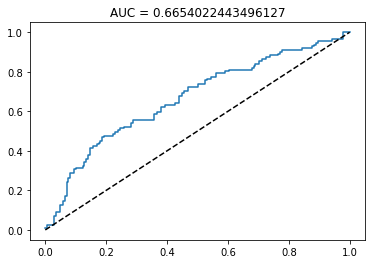

##### Factor Technical RNA-seq 

{'Accuracy': 0.59219858156028371,
 'Precision': 0.5,
 'Sensitivity': 0.20869565217391303,
 'Specificity': 0.85628742514970058}

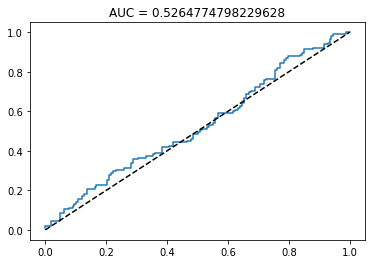

##### Factor Technical RPPA 

{'Accuracy': 0.57446808510638303,
 'Precision': 0.58666666666666667,
 'Sensitivity': 0.83018867924528306,
 'Specificity': 0.24390243902439024}

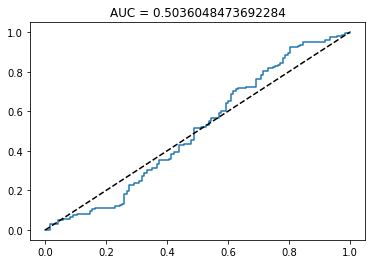

##### Factor Immune 

{'Accuracy': 0.55319148936170215,
 'Precision': 0.52173913043478259,
 'Sensitivity': 0.4580152671755725,
 'Specificity': 0.63576158940397354}

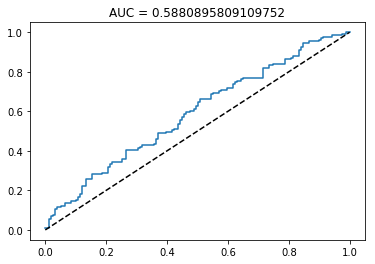

##### Factor HER2 

{'Accuracy': 0.78014184397163122,
 'Precision': 0.80000000000000004,
 'Sensitivity': 0.95412844036697253,
 'Specificity': 0.1875}

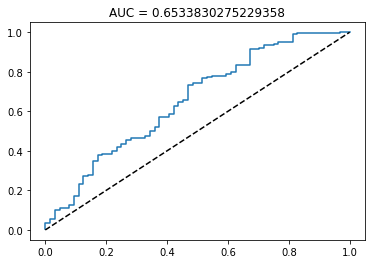

##### Factor Normal-like / ILC 

{'Accuracy': 0.61702127659574468,
 'Precision': 0.6097560975609756,
 'Sensitivity': 0.69444444444444442,
 'Specificity': 0.53623188405797106}

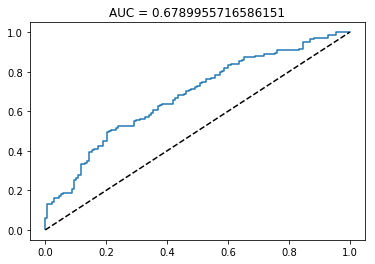

##### Factor Basal 

{'Accuracy': 0.57092198581560283,
 'Precision': 0.50666666666666671,
 'Sensitivity': 0.31147540983606559,
 'Specificity': 0.76875000000000004}

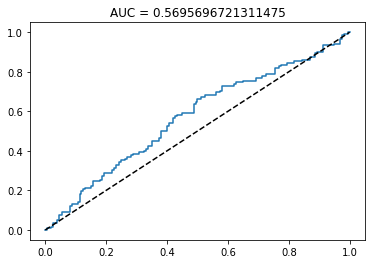

##### Factor Chr8 

{'Accuracy': 0.49645390070921985,
 'Precision': 0.42857142857142855,
 'Sensitivity': 0.27692307692307694,
 'Specificity': 0.68421052631578949}

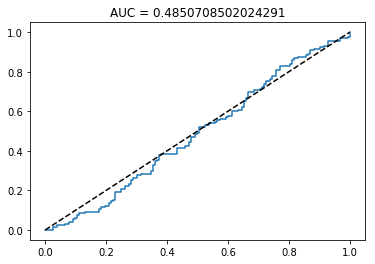

In [16]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values

# Make factors binary
y_real = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = np.zeros(y_real.shape, dtype=np.bool)
for factor_i in range(y.shape[1]):
    kmeans = sklearn.cluster.KMeans(2)
    kmeans.fit(y_real[:, [factor_i]])
    y[:, factor_i] = np.array(kmeans.labels_ == 1)

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLog(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(bin_performance(y[:, factor_i], y_pred))
    plot_roc(y[:, factor_i], y_pred)

# Predict Factors from MRI features in ER+ #

## Linear Regression ##

Number of samples: 223

##### Factor ER 

{'MSE': 1.0440754184577785}

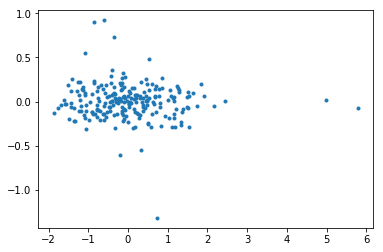

##### Factor EMT 

{'MSE': 1.0730234761186233}

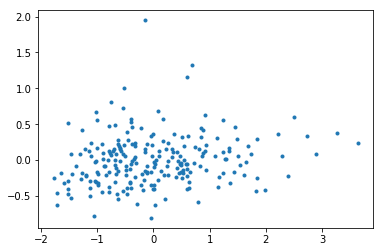

##### Factor Luminal Proliferative 

{'MSE': 1.0295048692926279}

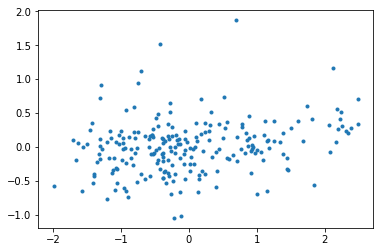

##### Factor Technical RNA-seq 

{'MSE': 0.99775173109477655}

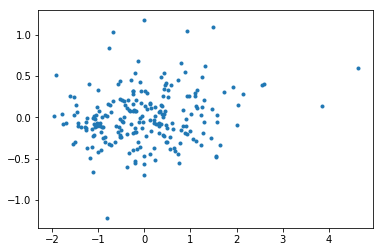

##### Factor Technical RPPA 

{'MSE': 1.0287532885928934}

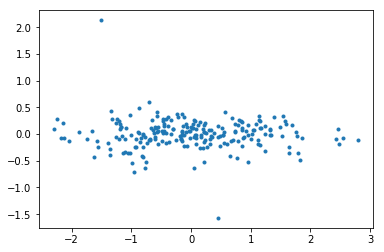

##### Factor Immune 

{'MSE': 1.0077708292665113}

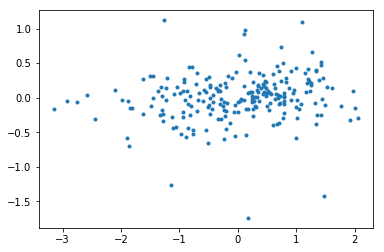

##### Factor HER2 

{'MSE': 1.0371371706988817}

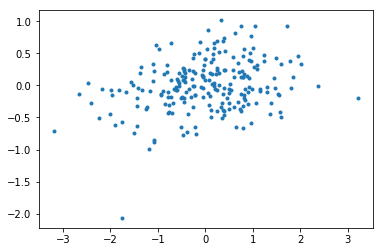

##### Factor Normal-like / ILC 

{'MSE': 0.94823507434628374}

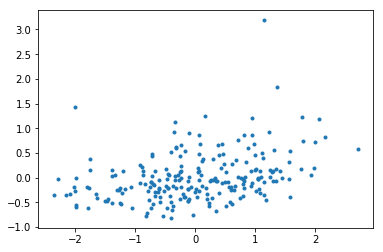

##### Factor Basal 

{'MSE': 1.0292871614994641}

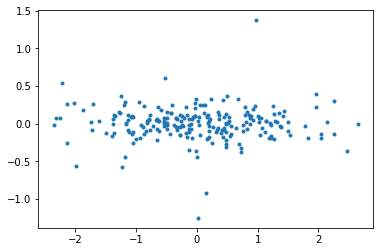

##### Factor Chr8 

{'MSE': 0.99764447778041776}

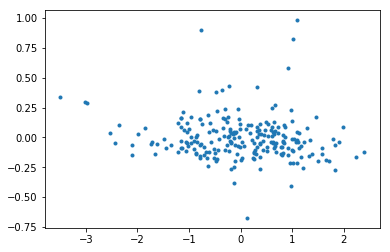

In [17]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0} &
    {p for t, p in zip(clin['ihc_subtype'], clin['patient'].values)
     if t in ['ER+/HER2-']})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values
y = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = (y - np.mean(y, 0, keepdims=True)) / np.std(y, 0, keepdims=True)

display(Markdown("Number of samples: {}".format(X.shape[0])))

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLin(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(mse_performance(y[:, factor_i], y_pred))
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(y[:, factor_i], y_pred, '.')  

## Logistic Regression ##

Number of samples: 223

##### Factor ER 

{'Accuracy': 0.6188340807174888,
 'Precision': 0.0,
 'Sensitivity': 0.0,
 'Specificity': 0.971830985915493}

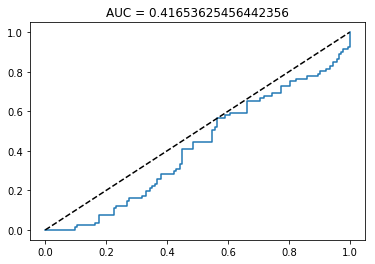

##### Factor EMT 

{'Accuracy': 0.5605381165919282,
 'Precision': 0.61538461538461542,
 'Sensitivity': 0.80000000000000004,
 'Specificity': 0.15662650602409639}

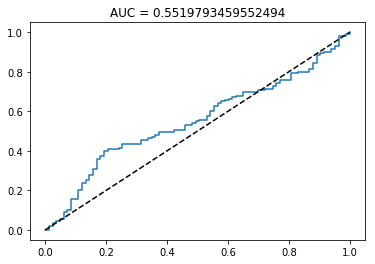

##### Factor Luminal Proliferative 

{'Accuracy': 0.68161434977578472,
 'Precision': 0.45833333333333331,
 'Sensitivity': 0.15942028985507245,
 'Specificity': 0.91558441558441561}

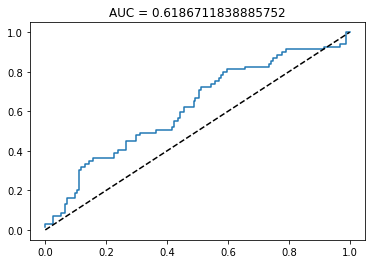

##### Factor Technical RNA-seq 

{'Accuracy': 0.54260089686098656,
 'Precision': 0.46575342465753422,
 'Sensitivity': 0.35051546391752575,
 'Specificity': 0.69047619047619047}

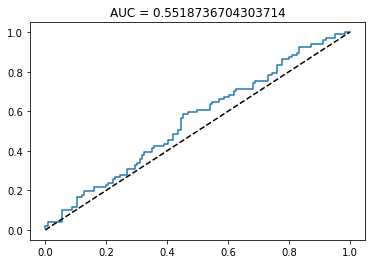

##### Factor Technical RPPA 

{'Accuracy': 0.50224215246636772,
 'Precision': 0.30952380952380953,
 'Sensitivity': 0.1368421052631579,
 'Specificity': 0.7734375}

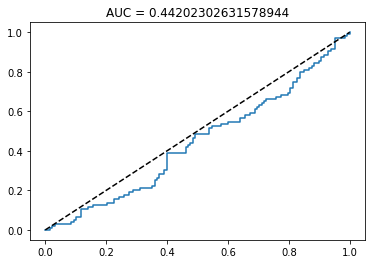

##### Factor Immune 

{'Accuracy': 0.60538116591928248,
 'Precision': 0.55555555555555558,
 'Sensitivity': 0.41666666666666669,
 'Specificity': 0.74803149606299213}

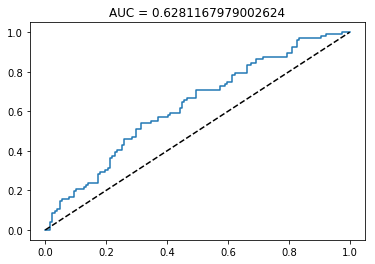

##### Factor HER2 

{'Accuracy': 0.5964125560538116,
 'Precision': 0.53164556962025311,
 'Sensitivity': 0.44210526315789472,
 'Specificity': 0.7109375}

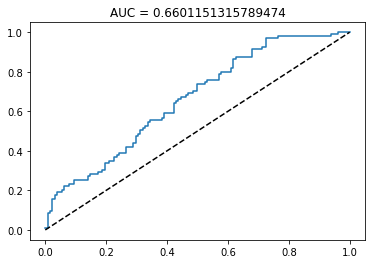

##### Factor Normal-like / ILC 

{'Accuracy': 0.62780269058295968,
 'Precision': 0.61240310077519378,
 'Sensitivity': 0.7053571428571429,
 'Specificity': 0.5495495495495496}

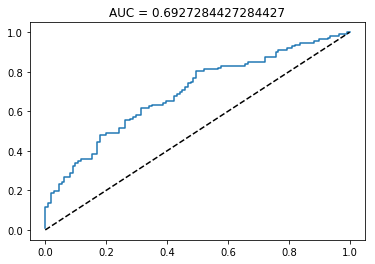

##### Factor Basal 

{'Accuracy': 0.49775784753363228,
 'Precision': 0.4854368932038835,
 'Sensitivity': 0.45871559633027525,
 'Specificity': 0.53508771929824561}

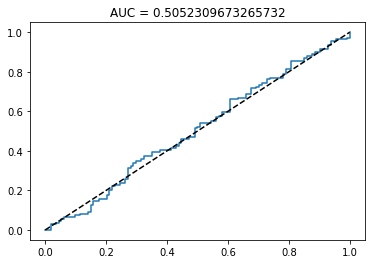

##### Factor Chr8 

{'Accuracy': 0.4170403587443946,
 'Precision': 0.44137931034482758,
 'Sensitivity': 0.5663716814159292,
 'Specificity': 0.26363636363636361}

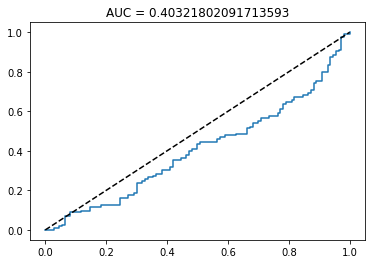

In [18]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0} &
    {p for t, p in zip(clin['ihc_subtype'], clin['patient'].values)
     if t in ['ER+/HER2-']})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values

# Make factors binary
y_real = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = np.zeros(y_real.shape, dtype=np.bool)
for factor_i in range(y.shape[1]):
    kmeans = sklearn.cluster.KMeans(2)
    kmeans.fit(y_real[:, [factor_i]])
    y[:, factor_i] = np.array(kmeans.labels_ == 1)

display(Markdown("Number of samples: {}".format(X.shape[0])))

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLog(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(bin_performance(y[:, factor_i], y_pred))
    plot_roc(y[:, factor_i], y_pred)

# Predict Factors from MRI features in TN / HER2+ #

## Linear Regression ##

Number of samples: 59

##### Factor ER 

{'MSE': 1.1216460083321087}

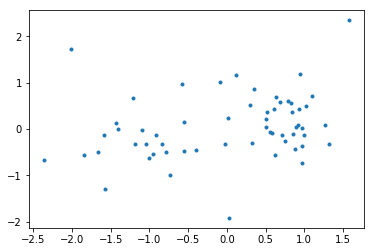

##### Factor EMT 

{'MSE': 1.1237345105211336}

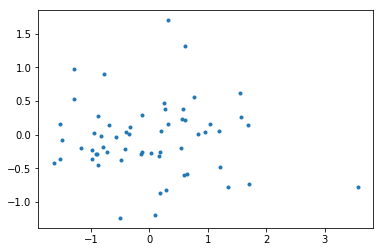

##### Factor Luminal Proliferative 

{'MSE': 1.1012254836576629}

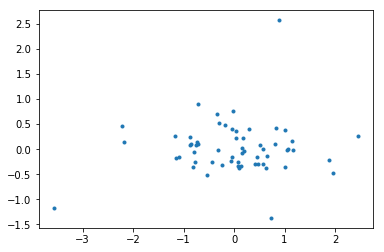

##### Factor Technical RNA-seq 

{'MSE': 1.1887320115763713}

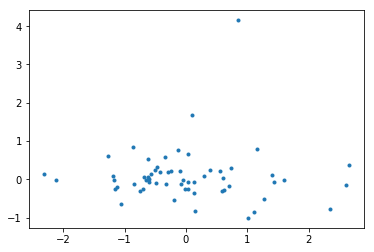

##### Factor Technical RPPA 

{'MSE': 1.0985626806968674}

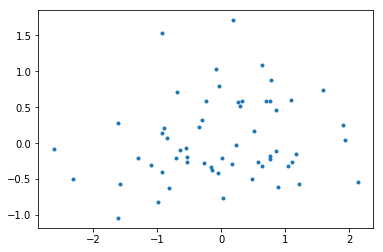

##### Factor Immune 

{'MSE': 1.1084005469657932}

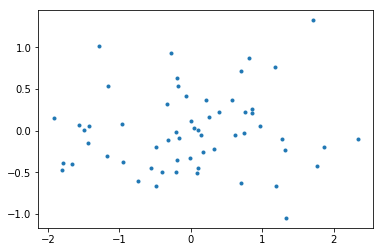

##### Factor HER2 

{'MSE': 1.1638975427982958}

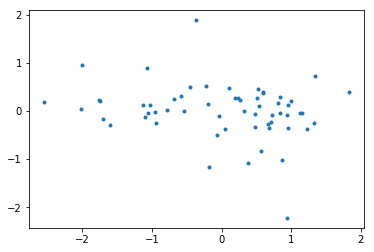

##### Factor Normal-like / ILC 

{'MSE': 1.0304304097655272}

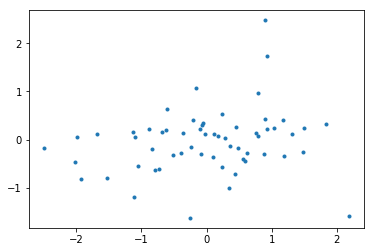

##### Factor Basal 

{'MSE': 1.1262024052609074}

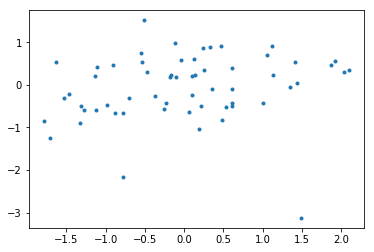

##### Factor Chr8 

{'MSE': 1.1614759968144424}

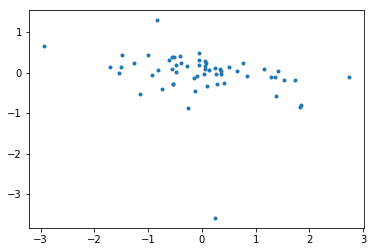

In [19]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0} &
    {p for t, p in zip(clin['ihc_subtype'], clin['patient'].values)
     if t in ['TN', 'HER2+']})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values
y = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = (y - np.mean(y, 0, keepdims=True)) / np.std(y, 0, keepdims=True)

display(Markdown("Number of samples: {}".format(X.shape[0])))

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLin(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(mse_performance(y[:, factor_i], y_pred))
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(y[:, factor_i], y_pred, '.')  

## Logistic Regression ##

Number of samples: 59

##### Factor ER 

{'Accuracy': 0.6271186440677966,
 'Precision': 0.5,
 'Sensitivity': 0.5,
 'Specificity': 0.70270270270270274}

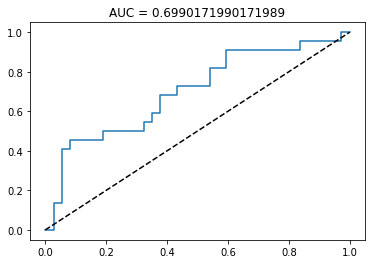

##### Factor EMT 

{'Accuracy': 0.49152542372881358,
 'Precision': 0.4838709677419355,
 'Sensitivity': 0.51724137931034486,
 'Specificity': 0.46666666666666667}

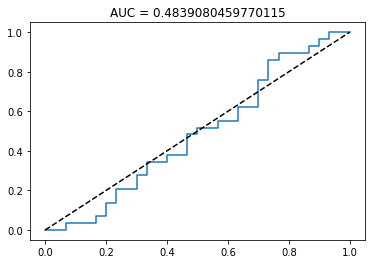

##### Factor Luminal Proliferative 

{'Accuracy': 0.5423728813559322,
 'Precision': 0.61904761904761907,
 'Sensitivity': 0.70270270270270274,
 'Specificity': 0.27272727272727271}

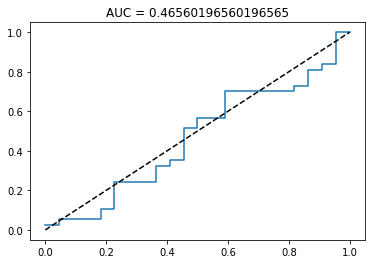

##### Factor Technical RNA-seq 

{'Accuracy': 0.59322033898305082,
 'Precision': 0.25,
 'Sensitivity': 0.16666666666666666,
 'Specificity': 0.78048780487804881}

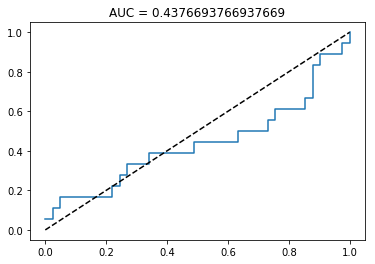

##### Factor Technical RPPA 

{'Accuracy': 0.55932203389830504,
 'Precision': 0.5714285714285714,
 'Sensitivity': 0.64516129032258063,
 'Specificity': 0.4642857142857143}

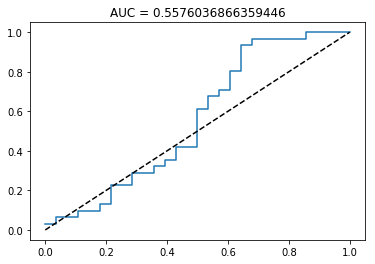

##### Factor Immune 

{'Accuracy': 0.47457627118644069,
 'Precision': 0.5,
 'Sensitivity': 0.54838709677419351,
 'Specificity': 0.39285714285714285}

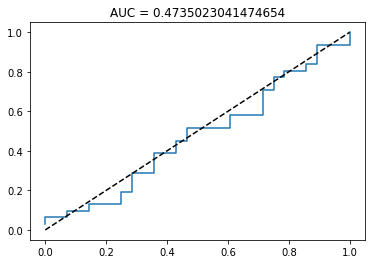

##### Factor HER2 

{'Accuracy': 0.50847457627118642,
 'Precision': 0.0,
 'Sensitivity': 0.0,
 'Specificity': 0.76923076923076927}

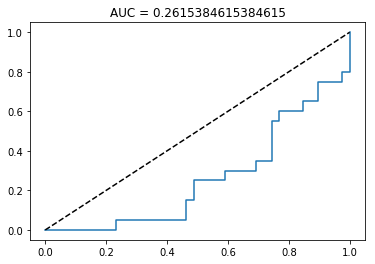

##### Factor Normal-like / ILC 

{'Accuracy': 0.6271186440677966,
 'Precision': 0.45000000000000001,
 'Sensitivity': 0.45000000000000001,
 'Specificity': 0.71794871794871795}

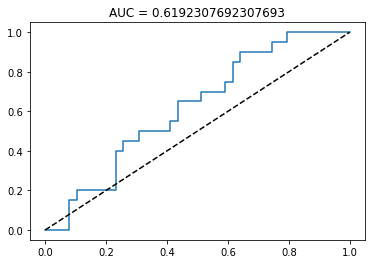

##### Factor Basal 

{'Accuracy': 0.57627118644067798,
 'Precision': 0.57692307692307687,
 'Sensitivity': 0.51724137931034486,
 'Specificity': 0.6333333333333333}

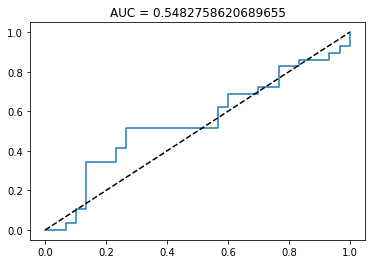

##### Factor Chr8 

{'Accuracy': 0.67796610169491522,
 'Precision': 0.75,
 'Sensitivity': 0.8666666666666667,
 'Specificity': 0.071428571428571425}

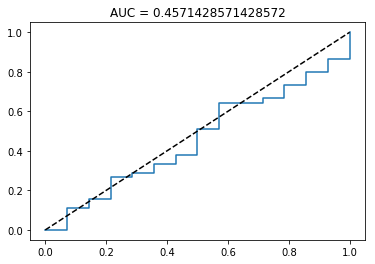

In [20]:
sel_patients = list(
    set(sfa['patient'].values) &
    {p for n, p in zip(np.isnan(mri_array).sum('variable'), mri_array['patient'].values)
     if n == 0} &
    {p for t, p in zip(clin['ihc_subtype'], clin['patient'].values)
     if t in ['TN', 'HER2+']})
X = mri_array.reindex(patient=sel_patients).transpose('patient', 'variable').values

# Make factors binary
y_real = sfa['factors'].reindex(patient=sel_patients).transpose('patient', 'factor').values
y = np.zeros(y_real.shape, dtype=np.bool)
for factor_i in range(y.shape[1]):
    kmeans = sklearn.cluster.KMeans(2)
    kmeans.fit(y_real[:, [factor_i]])
    y[:, factor_i] = np.array(kmeans.labels_ == 1)

display(Markdown("Number of samples: {}".format(X.shape[0])))

for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLog(10)
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['factor_name'][factor_i].item())))
    display(bin_performance(y[:, factor_i], y_pred))
    plot_roc(y[:, factor_i], y_pred)